<a href="https://colab.research.google.com/github/kboyles8/CAP4630/blob/master/HW_4/HW4_P3_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 3: Part 1

In this problem, the notebook https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF is modified to use the DenseNet121 convolutional neural network instead.

For Part 1, the binary classification method is used. This was the method used in the original notebook.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the DenseNet121 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Use Tensorflow 2.0

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-08 22:38:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  72.8MB/s    in 0.9s    

2020-04-08 22:38:59 (72.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with DenseNet121 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from tensorflow.keras.applications import DenseNet121

conv_base = DenseNet121(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4194560   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 11,232,321
Trainable params: 4,194,817
Non-trainable params: 7,037,504
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 20s 199ms/step - loss: 0.3055 - acc: 0.8800 - val_loss: 0.1244 - val_acc: 0.9490
Epoch 2/30
100/100 [==============================] - 19s 189ms/step - loss: 0.1915 - acc: 0.9225 - val_loss: 0.0933 - val_acc: 0.9620
Epoch 3/30
100/100 [==============================] - 19s 186ms/step - loss: 0.1936 - acc: 0.9145 - val_loss: 0.0829 - val_acc: 0.9660
Epoch 4/30
100/100 [==============================] - 18s 183ms/step - loss: 0.1672 - acc: 0.9370 - val_loss: 0.0537 - val_acc: 0.9750
Epoch 5/30
100/100 [==============================] - 18s 184ms/step - loss: 0.1394 - acc: 0.9405 - val_loss: 0.0918 - val_acc: 0.9610
Epoch 6/30
100/100 [==============================] - 18s 182ms/step - loss: 0.1328 - acc: 0.9440 - val_loss: 0.0841 - val_acc: 0.9680
Epoch 7/30
100/100 [==============================] - 18s 181ms/step - loss: 0.1242 - acc: 0.9415 - val_lo

## Display curves of loss and accuracy during training

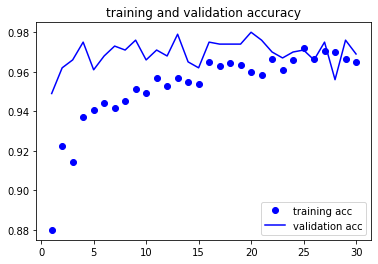

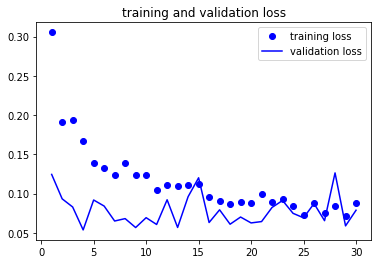

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

Fine-tuning has been modified to unfreeze the layer `conv5_block1_0_bn`, and all following layers.

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block1_0_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 [==============================] - 20s 197ms/step - loss: 0.1561 - acc: 0.9395 - val_loss: 0.0662 - val_acc: 0.9700
Epoch 2/30
100/100 [==============================] - 18s 183ms/step - loss: 0.1520 - acc: 0.9355 - val_loss: 0.0694 - val_acc: 0.9720
Epoch 3/30
100/100 [==============================] - 18s 185ms/step - loss: 0.1395 - acc: 0.9445 - val_loss: 0.0713 - val_acc: 0.9650
Epoch 4/30
100/100 [==============================] - 18s 182ms/step - loss: 0.1536 - acc: 0.9380 - val_loss: 0.0611 - val_acc: 0.9700
Epoch 5/30
100/100 [==============================] - 19s 185ms/step - loss: 0.1428 - acc: 0.9440 - val_loss: 0.0548 - val_acc: 0.9760
Epoch 6/30
100/100 [==============================] - 18s 182ms/step - loss: 0.1237 - acc: 0.9460 - val_loss: 0.0682 - val_acc: 0.9740
Epoch 7/30
100/100 [==============================] - 18s 183ms/step - loss: 0.1093 - acc: 0.9575 - val_loss: 0.05

## Display learning curves during fine-tuning

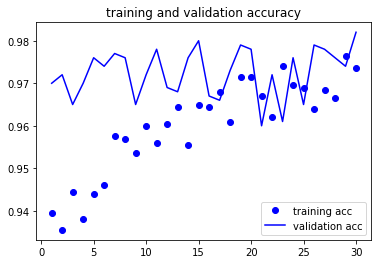

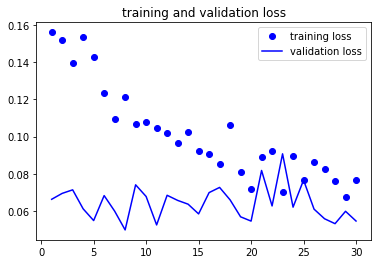

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [14]:
val_loss, val_acc = model.evaluate(validation_generator, steps=50)

50/50 [==============================] - 3s 61ms/step - loss: 0.0502 - acc: 0.9810


In [15]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.05018634721636772
Validation accuracy: 0.9810000061988831
